In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Background removal algorithm 
- foreground-background segmentation methods
- connected component analysis
- chan-vese segmentation
- mumford shah 
- graph partitioning methods


In [2]:
def remove_background(img):
    #== Parameters =======================================================================
    BLUR = 5
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 100
    MASK_DILATE_ITER = 20
    MASK_ERODE_ITER = 20
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format
    
    #== Processing =======================================================================
    cv2.imshow('input image',img)
    #-- Read image -----------------------------------------------------------------------
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    cv2.imshow('Canny',edges)
    edges = cv2.dilate(edges, None)
    cv2.imshow('Dialation',edges)
    edges = cv2.erode(edges, None)
    cv2.imshow('Erosion',edges)
    
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))
    # cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    
    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending
    
    masked = (mask_stack * img) + ((1 - mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    cv2.imshow('Final output', masked)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [3]:
image=cv2.imread('mosque35.png')
remove_background(image)

## BackgroundSubtractorMOG2

In [9]:
import numpy as np
import cv2

image = cv2.imread('building43.png')
fgbg = cv2.createBackgroundSubtractorMOG2()
fgmask = fgbg.apply(image)
cv2.imshow('frame',fgmask)
cv2.waitKey()
cv2.destroyAllWindows()

## BackgroundSubtractorGMG

In [13]:
image = cv2.imread('building43.png')
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorKNN()
fgmask = fgbg.apply(image)
fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
cv2.imshow('input',image)
cv2.imshow('frame',fgmask)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# creating object 
fgbg1 = cv2.createBackgroundSubtractorMOG2()    
fgbg2 = cv2.createBackgroundSubtractorMOG2()
fgbg3 = cv2.createBackgroundSubtractorKNN() 
  
# capture frames from a camera  
cap = cv2.VideoCapture(0)
while(1): 
    # read frames 
    ret, img = cap.read() 
      
    # apply mask for background subtraction 
    fgmask1 = fgbg1.apply(img)
    fgmask2 = fgbg2.apply(img) 
    fgmask3 = fgbg3.apply(img) 
      
    cv2.imshow('Original', img) 
    cv2.imshow('MOG', fgmask1) 
    cv2.imshow('MOG2', fgmask2) 
    cv2.imshow('GMG', fgmask3) 
    k = cv2.waitKey(30) & 0xff 
    if k == 27: 
        break 
    cap.release() 
cv2.destroyAllWindows()

## Connected component analysis

In [4]:
import cv2
import numpy as np

img = cv2.imread('mosque35.png', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels_im = cv2.connectedComponents(img)
print('num labels',num_labels)
print('label image',labels_im)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(200*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2.imshow('input',img)
    cv2.imshow('labeled.png', labeled_img)
    cv2.waitKey()
    cv2.destroyAllWindows()

imshow_components(labels_im)

num labels 564
label image [[  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 ...
 [563 563 563 ... 563 563 563]
 [563 563 563 ... 563 563 563]
 [563 563 563 ... 563 563 563]]


## Chan Vese Segmentation

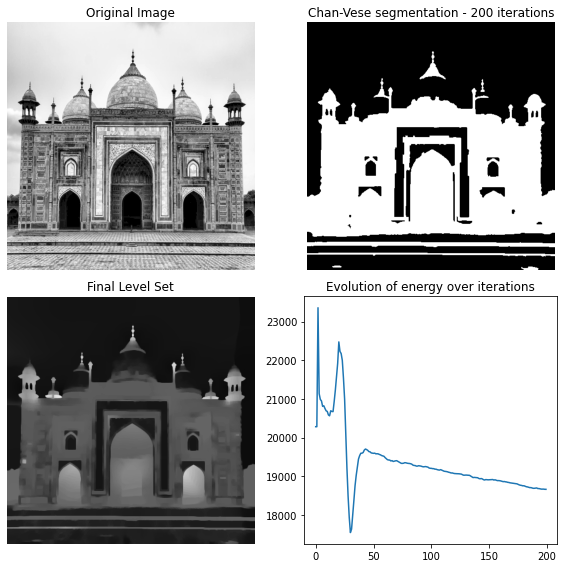

In [5]:
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese
image=cv2.imread('mosque35.png',0)
image = img_as_float(image)
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()